## Fine-Tuning LayoutLMv3 Using FUNSD Dataset

Dataset Source: https://huggingface.co/datasets/nielsr/funsd-layoutlmv3

#### Install Necessary Libraries

In [1]:
%pip install datasets transformers tensorboard seqeval accelerate torch -U

Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [2]:
import os, sys


import numpy as np

import datasets
from datasets.features import ClassLabel
from datasets import (
    load_dataset,
    Features,
    Sequence,
    ClassLabel,
    Value,
    Array2D,
    Array3D
)

import torch

import transformers
from transformers import (
    AutoProcessor,
    Trainer,
    TrainingArguments,
    LayoutLMv3ForTokenClassification
)

from transformers.data.data_collator import default_data_collator

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [27]:
library_len = 14
version_len = 12

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|",
      "Library".rjust(library_len),
      "|",
      "Version".ljust(version_len),
      "|")

print(f"|{'-' * (library_len + version_len + 5)}|")

print("|",
      "Python".rjust(library_len),
      "|",
      sys.version[0:6].ljust(version_len),
      "|")

print("|",
      "NumPy".rjust(library_len),
      "|",
      np.__version__.ljust(version_len),
      "|")

print("|",
      "Evaluate".rjust(library_len),
      "|",
      evaluate.__version__.ljust(version_len),
      "|")

print("|",
      "Datasets".rjust(library_len),
      "|",
      datasets.__version__.ljust(version_len),
      "|")

print("|",
      "Transformer".rjust(library_len),
      "|",
      transformers.__version__.ljust(version_len),
      "|")

print(f"+{'-' * (library_len + version_len + 5)}+")

+-------------------------------+
|        Library | Version      |
|-------------------------------|
|         Python | 3.9.12       |
|          NumPy | 1.25.1       |
|       Evaluate | 0.4.0        |
|       Datasets | 2.14.5       |
|    Transformer | 4.33.2       |
+-------------------------------+


#### Load Dataset

In [4]:
DATASET_NAME = "nielsr/funsd-layoutlmv3"

data = load_dataset(DATASET_NAME)

data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

#### Display More Information About Dataset

In [5]:
data['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

#### Display A Sample

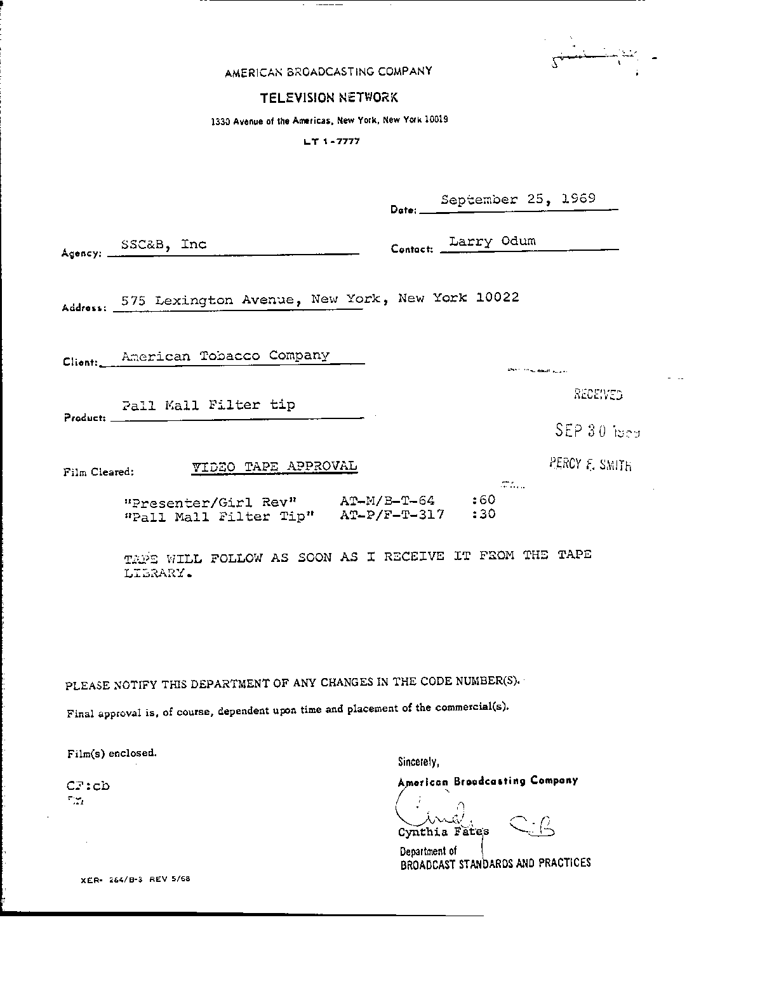

In [6]:
sample = data['train'][23]

sample["image"]

#### More Information About Sample Image

In [7]:
words, bboxes, tags = sample["tokens"], sample["bboxes"], sample["ner_tags"]

print(f"Words: \n{words}")
print(f"\nBoxes: \n{bboxes}")
print(f"\nTags: \n{tags}")

Words: 
['Agency:', 'Contact:', 'Date:', 'Client:', 'Address:', 'Product:', 'Film Cleared:', 'RECEIVED', 'CF:', 'cb', 'AMERICAN', 'BROADCASTING', 'COMPANY', 'TELEVISION', 'NETWORK', '1333', 'Avenue', 'of', 'the', 'Americas,', 'New', 'York,', 'New', 'York', '10019', 'LT', '1-', '7777', 'SSC&B,', 'Inc', 'September', '25,', '1969', 'Larry', 'Odum', '575', 'Lexington', 'Avenue,', 'New', 'York,', 'New', 'York', '10022', 'American', 'Tobacco', 'Company', 'Pall', 'Mail', 'Filter', 'tip', 'VIDEO', 'TAPE', 'APPROVAL', 'SEP', '30', 'PERCY', 'F.', 'SMITH', '"Presenter/', 'Girl', 'Rev"', 'AT-M', 'B-T-64', ':60', '"Pall', 'Mall', 'Filter', 'Tip"', 'AT-P/', 'F-T-317', ':30', 'TAPE', 'WILL', 'FOLLOW', 'AS', 'SOON', 'AS', 'I', 'RECEIVE', 'IT', 'FROM', 'THE', 'TAPE', 'LIBRARY.', 'PLEASE', 'NOTIFY', 'THIS', 'DEPARTMENT', 'OF', 'ANY', 'CHANGES', 'IN', 'THE', 'CODE', 'NUMBER(S).', 'Final', 'approval', 'is,', 'of', 'course,', 'dependent', 'upon', 'time', 'and', 'placement', 'of', 'the', 'commercial(s\uf703

#### Define Basic Values/Constants

In [8]:
MODEL_CKPT = "microsoft/layoutlmv3-base"
DATASET_DESCRIPTION = "FUNSD_dataset"

MODEL_NAME = f"{MODEL_CKPT.split('/')[-1]}-fine_tuned-{DATASET_DESCRIPTION}"
LR = 1e-5

BATCH_SIZE = 2
REPORTS_TO = "tensorboard"

MAX_STEPS = 2000
STRATEGY = "steps"

BEST_METRIC = "f1"

#### Define Processor

In [9]:
processor = AutoProcessor.from_pretrained(MODEL_CKPT,
                                          apply_ocr=False)

#### Define Conversions Between String & Integer

In [10]:
features = data['train'].features
col_names = data['train'].column_names
image_col_name = "image"
text_col_name = "tokens"
bboxes_col_name = "bboxes"
label_col_name = "ner_tags"

def define_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_col_name].feature, ClassLabel):
    label_list = features[label_col_name].feature.names
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = define_label_list(data['train'][label_col_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}

NUM_OF_LABELS = len(label_list)

print(f"Unique Labels:\n{label_list}")
print(f"Number of Labels:\n{NUM_OF_LABELS}")
print(f"id2label:\n{id2label}")
print(f"label2id:\n{label2id}")

Unique Labels:
['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
Number of Labels:
7
id2label:
{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}
label2id:
{'O': 0, 'B-HEADER': 1, 'I-HEADER': 2, 'B-QUESTION': 3, 'I-QUESTION': 4, 'B-ANSWER': 5, 'I-ANSWER': 6}


#### Define Preprocessing Function

In [11]:
def preprocess_dataset(samples):
    images = samples[image_col_name]
    words = samples[text_col_name]
    bboxes = samples[bboxes_col_name]
    word_labels = samples[label_col_name]
    
    encoding = processor(
        images, 
        words, 
        boxes=bboxes, 
        word_labels=word_labels, 
        truncation=True, 
        padding="max_length"
        )
    
    return encoding

#### Define Feature Format

In [12]:
feature_format = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype='int64', shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

#### Apply Preprocessing & Format to Both Training & Evaluation Datasets

In [13]:
train_ds = data['train'].map(
    preprocess_dataset,
    batched=True,
    remove_columns=col_names,
    features=feature_format,
)

eval_ds = data["test"].map(
    preprocess_dataset,
    batched=True,
    remove_columns=col_names,
    features=feature_format,
)

#### Show Dataset Features & Number of Samples

In [14]:
train_ds

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

#### Show Example (Both Before & After Preprocessing)

In [15]:
another_sample = train_ds[12]

processor.tokenizer.decode(another_sample['input_ids'])

'<s> ( ) ( ) ( ( ) B( ) ( ) ( ) ( ) ( ) ( ) ( ) ( ) ( ) BROWN & WILLAMSON 1994 COLLECTION PROTOCOPYING VARIANCE FORM This form was placed before Bates ID 6708105266 AT THE TIME OF REPRODUCTION, THE FOLLOWING NOTATTONS WERE MADE: DOCUMENT COPIES ARE IN THE SAME SEQUENCE AS THEY APPEARED IN THE ORIGINAL. PAGE NUMBER(S) WERE MISSING IN THE ORIGINAL. ☑ ) POOR QUALITY ORIGINAL. faded OVERLAY ITEM COULD NOT BE REMOVED WITHOUT DAMAGE TO THE ORIGINAL. NG DOCUMENTS WERE FOUND WITHIN THE ORIGINAL: FILE FOLDER REDROPE EXPANDABLE FILE HANGING FILE ENVELOPE OTHER (SPECIFY) DOCUMENT COPIES WERE REPRODUCED IN COLOR PERMIT CORRECTION INTERPRETATION BATES NUMBER NOT USED. OTHER VARIANCE (EXPLAIN).</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

#### Set Format to PyTorch

In [16]:
train_ds.set_format("torch")

#### Check To Ensure Data Is Ready For Training

In [17]:
eval_ds

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 50
})

In [18]:
processor.tokenizer.decode(eval_ds[12]["input_ids"])

'<s> 82573104 Date: To: From: Room: MESSAGE: COVINGTON & BURLING xc: RB5 12- 9- 99 RECEIVED DEC -9 1999 R B. SPELL 1201 Pennsylvania Avenue, N W. P. O. Box 7566 Washington D. C. 20044- 7566 (202) 662- 6000 Fax Numbers (202) 662 6291 or (202) 737 0528 Fax Operator (202) 662- 6280 THIS FACSIMILE TRANSMISSION INTENDED ONLY FOR THE ADDRESSEE SHOWN BELOW LIT MAY CONTAIN INFORMATION THAT IS PRIVILEGED CONFIDENTIAL OR OTHERWISE PROTECTED FROM DISCLOSURE ANY REVIEW DISSEMINATION OR USE OF THIS TRANSMISSION OR ITS CONTENTS BY PERSONS OTHER THAN THE ADDRESSEE IS STRICTLY PROHIBITED YOU HAVE RECEIVED THIS TRANSMISSION ERROR PLEASE NOTIFY US IMMEDIATELY AND MAIL THE ORIGINALI TO AT THE ABOVE ADDRESS December 9, 1999 Haney H. Bell, Esq. David H. Remes (202) 778 5212 - direct fax 803E // Pages (including cover)</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [19]:
for id, label in zip(train_ds[12]["input_ids"], 
                     train_ds[12]["labels"]):
    print(processor.tokenizer.decode([id]), 
          label.item())

<s> -100
 ( 0
 ) 0
 ( 0
 ) 0
 ( 0
 ( 0
 ) 0
 B 0
( -100
 ) 0
 ( 0
 ) 0
 ( 0
 ) 0
 ( 0
 ) 0
 ( 0
 ) 0
 ( 0
 ) 0
 ( 0
 ) 0
 ( 0
 ) 0
 ( 0
 ) 0
 BR 1
OWN -100
 & 2
 WILL 2
AM -100
SON -100
 1994 2
 COL 2
LECT -100
ION -100
 PROT 2
OC -100
OP -100
YING -100
 V 2
AR -100
IAN -100
CE -100
 FORM 2
 This 3
 form 4
 was 4
 placed 4
 before 4
 Bates 4
 ID 4
 6 5
708 -100
105 -100
266 -100
 AT 3
 THE 4
 TIME 4
 OF 4
 RE 4
PR -100
ODUCT -100
ION -100
, -100
 THE 4
 FO 4
LLOW -100
ING -100
 NOT 4
AT -100
TON -100
S -100
 W 4
ERE -100
 M 4
ADE -100
: -100
 DOC 0
UM -100
ENT -100
 COP 0
IES -100
 ARE 0
 IN 0
 THE 0
 S 0
AME -100
 SE 0
QU -100
ENCE -100
 AS 0
 THEY 0
 AP 0
PE -100
AR -100
ED -100
 IN 0
 THE 0
 ORIG 0
INAL -100
. -100
 PAGE 3
 NUM 4
BER -100
( -100
S -100
) -100
 W 4
ERE -100
 MISS 4
ING -100
 IN 4
 THE 4
 ORIG 4
INAL -100
. -100
 � 0
� 0
 ) 0
 PO 0
OR -100
 QU 0
AL -100
ITY -100
 ORIG 0
INAL -100
. -100
 faded 0
 OVER 0
L -100
AY -100
 IT 0
EM -100
 C 0
OULD -100
 NOT 0
 BE 0
 REM 0
O

#### Define Metrics

In [20]:
seqeval_metric = evaluate.load("seqeval")

return_entity_level_metrics = False

def compute_metrics(p):
    preds, labels = p
    
    preds = np.argmax(preds, 
                      axis=2)
    
    true_preds = [
        [label_list[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(preds, labels)
    ]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(preds, labels)
    ]
    
    results = seqeval_metric.compute(predictions=true_preds,
                                     references=true_labels)
    
    if return_entity_level_metrics:
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

#### Define Model

In [21]:
model = LayoutLMv3ForTokenClassification.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id
)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define TrainingArguments

In [22]:
args = TrainingArguments(
    MODEL_NAME,
    max_steps=MAX_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    evaluation_strategy=STRATEGY,
    eval_steps=100,
    logging_strategy=STRATEGY,
    logging_steps=25,
    save_strategy=STRATEGY,
    save_steps=100,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model=BEST_METRIC,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [23]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

#### Train Model

In [24]:
train_results = trainer.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.3161, 'learning_rate': 9.995000000000002e-06, 'epoch': 0.01}
{'loss': 0.4774, 'learning_rate': 9.875000000000001e-06, 'epoch': 0.33}
{'loss': 0.4193, 'learning_rate': 9.75e-06, 'epoch': 0.67}
{'loss': 0.288, 'learning_rate': 9.625e-06, 'epoch': 1.0}
{'loss': 0.2149, 'learning_rate': 9.5e-06, 'epoch': 1.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.24023552238941193, 'eval_precision': 0.7469498418436512, 'eval_recall': 0.8211624441132638, 'eval_f1': 0.7823000473260767, 'eval_accuracy': 0.7758231308688934, 'eval_runtime': 19.0647, 'eval_samples_per_second': 2.623, 'eval_steps_per_second': 1.311, 'epoch': 1.33}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.1748, 'learning_rate': 9.375000000000001e-06, 'epoch': 1.67}
{'loss': 0.2068, 'learning_rate': 9.250000000000001e-06, 'epoch': 2.0}
{'loss': 0.1391, 'learning_rate': 9.125e-06, 'epoch': 2.33}
{'loss': 0.1466, 'learning_rate': 9e-06, 'epoch': 2.67}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.18694068491458893, 'eval_precision': 0.8160550458715596, 'eval_recall': 0.8837555886736215, 'eval_f1': 0.8485571190078703, 'eval_accuracy': 0.827291097111613, 'eval_runtime': 18.9358, 'eval_samples_per_second': 2.64, 'eval_steps_per_second': 1.32, 'epoch': 2.67}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.144, 'learning_rate': 8.875e-06, 'epoch': 3.0}
{'loss': 0.1194, 'learning_rate': 8.750000000000001e-06, 'epoch': 3.33}
{'loss': 0.0955, 'learning_rate': 8.625000000000001e-06, 'epoch': 3.67}
{'loss': 0.1122, 'learning_rate': 8.5e-06, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.190227210521698, 'eval_precision': 0.8538425271098539, 'eval_recall': 0.899652260307998, 'eval_f1': 0.8761490082244799, 'eval_accuracy': 0.8315701889932248, 'eval_runtime': 18.9972, 'eval_samples_per_second': 2.632, 'eval_steps_per_second': 1.316, 'epoch': 4.0}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0824, 'learning_rate': 8.375e-06, 'epoch': 4.33}
{'loss': 0.1132, 'learning_rate': 8.25e-06, 'epoch': 4.67}
{'loss': 0.0705, 'learning_rate': 8.125000000000001e-06, 'epoch': 5.0}
{'loss': 0.0757, 'learning_rate': 8.000000000000001e-06, 'epoch': 5.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.18571239709854126, 'eval_precision': 0.8354253835425384, 'eval_recall': 0.8926974664679582, 'eval_f1': 0.8631123919308358, 'eval_accuracy': 0.8348983715678118, 'eval_runtime': 18.9124, 'eval_samples_per_second': 2.644, 'eval_steps_per_second': 1.322, 'epoch': 5.33}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0711, 'learning_rate': 7.875e-06, 'epoch': 5.67}
{'loss': 0.0667, 'learning_rate': 7.75e-06, 'epoch': 6.0}
{'loss': 0.0734, 'learning_rate': 7.625e-06, 'epoch': 6.33}
{'loss': 0.0427, 'learning_rate': 7.500000000000001e-06, 'epoch': 6.67}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.20910972356796265, 'eval_precision': 0.8792341678939617, 'eval_recall': 0.8897168405365127, 'eval_f1': 0.8844444444444444, 'eval_accuracy': 0.8446451919648164, 'eval_runtime': 18.8676, 'eval_samples_per_second': 2.65, 'eval_steps_per_second': 1.325, 'epoch': 6.67}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0587, 'learning_rate': 7.375000000000001e-06, 'epoch': 7.0}
{'loss': 0.0479, 'learning_rate': 7.25e-06, 'epoch': 7.33}
{'loss': 0.0484, 'learning_rate': 7.125e-06, 'epoch': 7.67}
{'loss': 0.0495, 'learning_rate': 7e-06, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.22346988320350647, 'eval_precision': 0.8825242718446602, 'eval_recall': 0.9031296572280179, 'eval_f1': 0.8927080775840904, 'eval_accuracy': 0.8370379175086177, 'eval_runtime': 19.0222, 'eval_samples_per_second': 2.629, 'eval_steps_per_second': 1.314, 'epoch': 8.0}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0416, 'learning_rate': 6.875e-06, 'epoch': 8.33}
{'loss': 0.0342, 'learning_rate': 6.750000000000001e-06, 'epoch': 8.67}
{'loss': 0.0615, 'learning_rate': 6.625e-06, 'epoch': 9.0}
{'loss': 0.0369, 'learning_rate': 6.5000000000000004e-06, 'epoch': 9.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.25323349237442017, 'eval_precision': 0.8825503355704698, 'eval_recall': 0.914555389965226, 'eval_f1': 0.8982678702122469, 'eval_accuracy': 0.8348983715678118, 'eval_runtime': 18.9516, 'eval_samples_per_second': 2.638, 'eval_steps_per_second': 1.319, 'epoch': 9.33}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0279, 'learning_rate': 6.375e-06, 'epoch': 9.67}
{'loss': 0.0427, 'learning_rate': 6.25e-06, 'epoch': 10.0}
{'loss': 0.0266, 'learning_rate': 6.125000000000001e-06, 'epoch': 10.33}
{'loss': 0.0329, 'learning_rate': 6e-06, 'epoch': 10.67}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2575645446777344, 'eval_precision': 0.8829268292682927, 'eval_recall': 0.8991554893194238, 'eval_f1': 0.8909672655673148, 'eval_accuracy': 0.8473790562225127, 'eval_runtime': 18.8965, 'eval_samples_per_second': 2.646, 'eval_steps_per_second': 1.323, 'epoch': 10.67}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0362, 'learning_rate': 5.8750000000000005e-06, 'epoch': 11.0}
{'loss': 0.0246, 'learning_rate': 5.75e-06, 'epoch': 11.33}
{'loss': 0.0243, 'learning_rate': 5.625e-06, 'epoch': 11.67}
{'loss': 0.0229, 'learning_rate': 5.500000000000001e-06, 'epoch': 12.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.25785550475120544, 'eval_precision': 0.8827281648675172, 'eval_recall': 0.8936910084451068, 'eval_f1': 0.8881757590718341, 'eval_accuracy': 0.8442886009746821, 'eval_runtime': 18.9059, 'eval_samples_per_second': 2.645, 'eval_steps_per_second': 1.322, 'epoch': 12.0}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0288, 'learning_rate': 5.375e-06, 'epoch': 12.33}
{'loss': 0.0198, 'learning_rate': 5.2500000000000006e-06, 'epoch': 12.67}
{'loss': 0.0184, 'learning_rate': 5.125e-06, 'epoch': 13.0}
{'loss': 0.0219, 'learning_rate': 5e-06, 'epoch': 13.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2710016965866089, 'eval_precision': 0.8709677419354839, 'eval_recall': 0.8986587183308494, 'eval_f1': 0.8845965770171149, 'eval_accuracy': 0.8346606442410555, 'eval_runtime': 18.888, 'eval_samples_per_second': 2.647, 'eval_steps_per_second': 1.324, 'epoch': 13.33}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0155, 'learning_rate': 4.875e-06, 'epoch': 13.67}
{'loss': 0.023, 'learning_rate': 4.75e-06, 'epoch': 14.0}
{'loss': 0.013, 'learning_rate': 4.625000000000001e-06, 'epoch': 14.33}
{'loss': 0.0191, 'learning_rate': 4.5e-06, 'epoch': 14.67}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.25823983550071716, 'eval_precision': 0.8888888888888888, 'eval_recall': 0.9061102831594635, 'eval_f1': 0.8974169741697418, 'eval_accuracy': 0.845358373945085, 'eval_runtime': 18.8546, 'eval_samples_per_second': 2.652, 'eval_steps_per_second': 1.326, 'epoch': 14.67}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0208, 'learning_rate': 4.3750000000000005e-06, 'epoch': 15.0}
{'loss': 0.0109, 'learning_rate': 4.25e-06, 'epoch': 15.33}
{'loss': 0.0148, 'learning_rate': 4.125e-06, 'epoch': 15.67}
{'loss': 0.0179, 'learning_rate': 4.000000000000001e-06, 'epoch': 16.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2646341919898987, 'eval_precision': 0.886986301369863, 'eval_recall': 0.9006458022851466, 'eval_f1': 0.8937638649248213, 'eval_accuracy': 0.8356115535480804, 'eval_runtime': 18.9126, 'eval_samples_per_second': 2.644, 'eval_steps_per_second': 1.322, 'epoch': 16.0}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0131, 'learning_rate': 3.875e-06, 'epoch': 16.33}
{'loss': 0.0108, 'learning_rate': 3.7500000000000005e-06, 'epoch': 16.67}
{'loss': 0.0197, 'learning_rate': 3.625e-06, 'epoch': 17.0}
{'loss': 0.0135, 'learning_rate': 3.5e-06, 'epoch': 17.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.27982670068740845, 'eval_precision': 0.8949152542372881, 'eval_recall': 0.9180327868852459, 'eval_f1': 0.9063266307013242, 'eval_accuracy': 0.8511826934506121, 'eval_runtime': 18.7335, 'eval_samples_per_second': 2.669, 'eval_steps_per_second': 1.335, 'epoch': 17.33}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0091, 'learning_rate': 3.3750000000000003e-06, 'epoch': 17.67}
{'loss': 0.0148, 'learning_rate': 3.2500000000000002e-06, 'epoch': 18.0}
{'loss': 0.0115, 'learning_rate': 3.125e-06, 'epoch': 18.33}
{'loss': 0.007, 'learning_rate': 3e-06, 'epoch': 18.67}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.29441899061203003, 'eval_precision': 0.8988212180746562, 'eval_recall': 0.9090909090909091, 'eval_f1': 0.9039268955297605, 'eval_accuracy': 0.845477237608463, 'eval_runtime': 19.1628, 'eval_samples_per_second': 2.609, 'eval_steps_per_second': 1.305, 'epoch': 18.67}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0168, 'learning_rate': 2.875e-06, 'epoch': 19.0}
{'loss': 0.0153, 'learning_rate': 2.7500000000000004e-06, 'epoch': 19.33}
{'loss': 0.0071, 'learning_rate': 2.6250000000000003e-06, 'epoch': 19.67}
{'loss': 0.0064, 'learning_rate': 2.5e-06, 'epoch': 20.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.28219303488731384, 'eval_precision': 0.8937836514929026, 'eval_recall': 0.907103825136612, 'eval_f1': 0.9003944773175543, 'eval_accuracy': 0.8452395102817069, 'eval_runtime': 19.2633, 'eval_samples_per_second': 2.596, 'eval_steps_per_second': 1.298, 'epoch': 20.0}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0068, 'learning_rate': 2.375e-06, 'epoch': 20.33}
{'loss': 0.0091, 'learning_rate': 2.25e-06, 'epoch': 20.67}
{'loss': 0.0093, 'learning_rate': 2.125e-06, 'epoch': 21.0}
{'loss': 0.0089, 'learning_rate': 2.0000000000000003e-06, 'epoch': 21.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.30030521750450134, 'eval_precision': 0.8940946803318692, 'eval_recall': 0.9100844510680576, 'eval_f1': 0.9020187099950762, 'eval_accuracy': 0.8484488291929158, 'eval_runtime': 19.1553, 'eval_samples_per_second': 2.61, 'eval_steps_per_second': 1.305, 'epoch': 21.33}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0085, 'learning_rate': 1.8750000000000003e-06, 'epoch': 21.67}
{'loss': 0.0073, 'learning_rate': 1.75e-06, 'epoch': 22.0}
{'loss': 0.0042, 'learning_rate': 1.6250000000000001e-06, 'epoch': 22.33}
{'loss': 0.0099, 'learning_rate': 1.5e-06, 'epoch': 22.67}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.30076491832733154, 'eval_precision': 0.8942213516160626, 'eval_recall': 0.907103825136612, 'eval_f1': 0.9006165228113441, 'eval_accuracy': 0.8439320099845478, 'eval_runtime': 19.5076, 'eval_samples_per_second': 2.563, 'eval_steps_per_second': 1.282, 'epoch': 22.67}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0082, 'learning_rate': 1.3750000000000002e-06, 'epoch': 23.0}
{'loss': 0.0108, 'learning_rate': 1.25e-06, 'epoch': 23.33}
{'loss': 0.0045, 'learning_rate': 1.125e-06, 'epoch': 23.67}
{'loss': 0.0069, 'learning_rate': 1.0000000000000002e-06, 'epoch': 24.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2965126931667328, 'eval_precision': 0.8942213516160626, 'eval_recall': 0.907103825136612, 'eval_f1': 0.9006165228113441, 'eval_accuracy': 0.838583145132533, 'eval_runtime': 19.1565, 'eval_samples_per_second': 2.61, 'eval_steps_per_second': 1.305, 'epoch': 24.0}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.005, 'learning_rate': 8.75e-07, 'epoch': 24.33}
{'loss': 0.0083, 'learning_rate': 7.5e-07, 'epoch': 24.67}
{'loss': 0.007, 'learning_rate': 6.25e-07, 'epoch': 25.0}
{'loss': 0.0048, 'learning_rate': 5.000000000000001e-07, 'epoch': 25.33}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2972734570503235, 'eval_precision': 0.9026679841897233, 'eval_recall': 0.9076005961251863, 'eval_f1': 0.9051275699777062, 'eval_accuracy': 0.8501129204802093, 'eval_runtime': 19.165, 'eval_samples_per_second': 2.609, 'eval_steps_per_second': 1.304, 'epoch': 25.33}


/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0059, 'learning_rate': 3.75e-07, 'epoch': 25.67}
{'loss': 0.0083, 'learning_rate': 2.5000000000000004e-07, 'epoch': 26.0}
{'loss': 0.0056, 'learning_rate': 1.2500000000000002e-07, 'epoch': 26.33}
{'loss': 0.0069, 'learning_rate': 0.0, 'epoch': 26.67}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2955743670463562, 'eval_precision': 0.8978890525282278, 'eval_recall': 0.9085941381023348, 'eval_f1': 0.9032098765432099, 'eval_accuracy': 0.8461904195887318, 'eval_runtime': 19.1955, 'eval_samples_per_second': 2.605, 'eval_steps_per_second': 1.302, 'epoch': 26.67}
{'train_runtime': 4359.3411, 'train_samples_per_second': 0.918, 'train_steps_per_second': 0.459, 'train_loss': 0.05324296360835433, 'epoch': 26.67}


#### Push Model To Hub & Save Model

In [25]:
trainer.push_to_hub()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =      26.67
  train_loss               =     0.0532
  train_runtime            = 1:12:39.34
  train_samples_per_second =      0.918
  train_steps_per_second   =      0.459


#### Evaluate Model

In [26]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =      26.67
  eval_accuracy           =     0.8512
  eval_f1                 =     0.9063
  eval_loss               =     0.2798
  eval_precision          =     0.8949
  eval_recall             =      0.918
  eval_runtime            = 0:00:19.42
  eval_samples_per_second =      2.574
  eval_steps_per_second   =      1.287


### Notes & Other Takeaways From This Project

****
- I am glad that I was able to get this working.
- I will perform inference using this trained model in a separate file.

****

### Citations

- Dataset
    > https://huggingface.co/datasets/nielsr/funsd-layoutlmv3

- Model Checkpoint
    > @inproceedings{huang2022layoutlmv3, author={Yupan Huang and Tengchao Lv and Lei Cui and Yutong Lu and Furu Wei}, title={LayoutLMv3: Pre-training for Document AI with Unified Text and Image Masking}, booktitle={Proceedings of the 30th ACM International Conference on Multimedia}, year={2022}}

- Metric
    - F1
        > @article{scikit-learn, title={Scikit-learn: Machine Learning in {P}ython}, author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.}, journal={Journal of Machine Learning Research}, volume={12}, pages={2825--2830}, year={2011}}

    - Accuracy
        > @article{scikit-learn, title={Scikit-learn: Machine Learning in {P}ython}, author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.}, journal={Journal of Machine Learning Research}, volume={12}, pages={2825--2830}, year={2011}}
    
    - Precision
        > @article{scikit-learn, title={Scikit-learn: Machine Learning in {P}ython}, author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.}, journal={Journal of Machine Learning Research}, volume={12}, pages={2825--2830}, year={2011}}
    
    - Recall
        > @article{scikit-learn, title={Scikit-learn: Machine Learning in {P}ython}, author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.}, journal={Journal of Machine Learning Research}, volume={12}, pages={2825--2830}, year={2011}}

